In [1]:
import os
import PIL
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import KFold
from tensorflow import keras

In [2]:
# Define the number of folds
num_folds = 5

# Define the data directory and batch size
data_dir = '/kaggle/input/preprocessed-brain-mri-images/brain-tumor/processed-images'
batch_size = 32
img_height = 224
img_width = 224

In [3]:
# Create a list to store the file paths and labels
data = []
labels = []

# Iterate over the subdirectories in the data directory
for subdir in os.listdir(data_dir):
    # Get the full path of the subdirectory
    subdir_path = os.path.join(data_dir, subdir)

    # Check if the subdirectory is a directory
    if os.path.isdir(subdir_path):
        # Iterate over the files in the subdirectory
        for filename in os.listdir(subdir_path):
            # Get the full path of the file
            file_path = os.path.join(subdir_path, filename)

            # Check if the file is an image
            if file_path.endswith('.jpg') or file_path.endswith('.png'):
                # Add the file path and label to the lists
                data.append(file_path)
                labels.append(subdir)

In [4]:
print(len(data))
print(len(labels))

12256
12256


In [5]:
# Create a DataFrame from the lists
df = pd.DataFrame({'filename': data, 'class': labels})

In [6]:
# Create a data generator for loading images in batches
datagen = keras.preprocessing.image.ImageDataGenerator()

In [7]:
# Define the k-fold cross-validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# Define a list to store the accuracy scores for each fold
acc_per_fold = []
metrics_per_fold = []
#save the model history in a list after fitting so that we can plot later
initial_training_history = []
fine_tuning_history = [] 

In [8]:
def initial_training(img_height, img_width, batch_size, datagen, train_df, val_df, initial_training_history):
    
    # Load this fold's training and validation data using the data generator
    train_data = datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    val_data = datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    base_model = tf.keras.applications.resnet50.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(img_height, img_width,3)
    )
    base_model.trainable = False
    
    image_batch, label_batch = next(iter(train_data))
    feature_batch = base_model(image_batch)
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    
    prediction_layer = keras.Sequential( [
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3)
    ])
    prediction_batch = prediction_layer(feature_batch_average)
    
    preprocess_input = tf.keras.applications.resnet50.preprocess_input
    
    # add classifier head or top
    inputs = tf.keras.Input(shape=(img_height, img_width,3) )
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.experimental.Adam(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    initial_epochs = 7
    history = model.fit(train_data,
                        epochs=initial_epochs,
                        validation_data=val_data)
    initial_training_history.append(history)
    return model

In [9]:
def create_model(model):
    base_model = model.get_layer(index=3)
    base_model.trainable = True
    # Fine-tune from this layer onwards
    fine_tune_at = 100

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
    base_learning_rate= 0.0001
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
                  metrics=['accuracy'])
    return model

In [10]:
def fine_tuning(img_height, img_width, batch_size, datagen, train_df, val_df, model, fine_tuning_history, acc_per_fold):
    # Load this fold's training and validation data using the data generator
    fine_tuning_epoch = 12
    
    train_data = datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    val_data = datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    fine_tuning_model = create_model(model)
    
    # Train the model on this fold's training data and evaluate on validation data
    history = fine_tuning_model.fit(train_data, validation_data=val_data, epochs=fine_tuning_epoch)
    fine_tuning_history.append(history)
    
    # Evaluate the model on this fold's validation data
    scores = fine_tuning_model.evaluate(val_data)
    acc_per_fold.append(scores[1])
    return fine_tuning_model

In [11]:
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score,
                             matthews_corrcoef, log_loss, classification_report, 
                             confusion_matrix, cohen_kappa_score,
                             jaccard_score, hamming_loss,
                             balanced_accuracy_score)

def calculate_metrics(y_true, y_prob, y_pred):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    target_names = ['class 1', 'class 2', 'class 3']
    metrics['classification_report'] = classification_report(y_true, y_pred, target_names=target_names)
    metrics['f1_weighted'] = f1_score(y_true, y_pred, average='weighted')
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro')
    metrics['f1_micro'] = f1_score(y_true, y_pred, average='micro')
    metrics['precision_weighted'] = precision_score(y_true, y_pred, average='weighted')
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro')
    metrics['precision_micro'] = precision_score(y_true, y_pred, average='micro')
    metrics['recall_weighted'] = recall_score(y_true, y_pred, average='weighted')
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro')
    metrics['recall_micro'] = recall_score(y_true, y_pred, average='micro')
    metrics['roc_auc_ovr_macro'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    metrics['roc_auc_ovr_weighted'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    metrics['roc_auc_ovo_macro'] = roc_auc_score(y_true, y_prob, multi_class='ovo', average='macro')
    metrics['roc_auc_ovo_weighted'] = roc_auc_score(y_true, y_prob, multi_class='ovo', average='weighted')
    metrics['matthews_corrcoef'] = matthews_corrcoef(y_true, y_pred)
    metrics['log_loss'] = log_loss(y_true, y_prob)
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    metrics['cohen_kappa'] = cohen_kappa_score(y_true,y_pred)
    metrics['jaccard_weighted'] = jaccard_score(y_true,y_pred ,average='weighted')
    metrics['jaccard_macro'] = jaccard_score(y_true,y_pred ,average='macro')
    metrics['jaccard_micro'] = jaccard_score(y_true,y_pred ,average='micro')
    metrics['hamming_loss'] = hamming_loss(y_true,y_pred)
    metrics['balanced_accuracy'] = balanced_accuracy_score(y_true,y_pred)
    
    return metrics

In [12]:
def prediction_and_analysis(img_height, img_width, batch_size, datagen, val_df, fine_tuned_model):
    val_data = datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )   
    y_true = []
    y_prob = []
    y_pred = []
    for i in range(val_data.samples // batch_size):
        X_val_batch, y_val_batch = next(val_data)
        y_true.append(y_val_batch)
        logits = fine_tuned_model.predict(X_val_batch)
        y_prob_batch = tf.nn.softmax(logits)
        y_prob.append(y_prob_batch)
        y_pred_batch = tf.argmax(y_prob_batch, axis=-1)
        y_pred.append(y_pred_batch)

    if val_data.samples % batch_size != 0:
        X_val_batch, y_val_batch = next(val_data)
        y_true.append(y_val_batch[:val_data.samples % batch_size])
        logits = fine_tuned_model.predict(X_val_batch[:val_data.samples % batch_size])
        y_prob_batch = tf.nn.softmax(logits)
        y_prob.append(y_prob_batch)
        y_pred_batch = tf.argmax(y_prob_batch, axis=-1)
        y_pred.append(y_pred_batch)

    y_true = np.concatenate(y_true)
    y_prob = np.concatenate(y_prob)
    y_pred = np.concatenate(y_pred)
    y_true = np.argmax(y_true, axis=-1)
    
    return  calculate_metrics(y_true, y_prob, y_pred)
    

In [13]:
fold = 1
stop_at_fold = num_folds
for train_index, test_index in kfold.split(df):
    # Print the fold number
    print(f'Fold {fold}/{num_folds}')

    # Get the training and validation data
    train_df = df.iloc[train_index]
    val_df = df.iloc[test_index]
    
    
    # Create a new instance of the model and train it
    model = initial_training(img_height, img_width, batch_size, datagen, train_df, val_df, initial_training_history)
    
    # Fine tuning
    fine_tuned_model = fine_tuning(img_height, img_width, batch_size, datagen, train_df, val_df, model, fine_tuning_history, acc_per_fold)
    
    # Prediction, analysis and metrics
    metrics = prediction_and_analysis(img_height, img_width, batch_size, datagen, val_df, fine_tuned_model)
    metrics_per_fold.append(metrics)
    if(fold == stop_at_fold):
        break
        
    fold += 1
    

Fold 1/5
Found 9804 validated image filenames belonging to 3 classes.
Found 2452 validated image filenames belonging to 3 classes.
Epoch 1/7
307/307 [==============================] - 36s 104ms/step - loss: 0.7469 - accuracy: 0.7075 - val_loss: 0.3533 - val_accuracy: 0.8662
Epoch 2/7
307/307 [==============================] - 33s 108ms/step - loss: 0.4653 - accuracy: 0.8193 - val_loss: 0.3068 - val_accuracy: 0.8809
Epoch 3/7
307/307 [==============================] - 32s 104ms/step - loss: 0.4016 - accuracy: 0.8390 - val_loss: 0.2943 - val_accuracy: 0.8903
Epoch 4/7
307/307 [==============================] - 31s 100ms/step - loss: 0.3691 - accuracy: 0.8498 - val_loss: 0.2757 - val_accuracy: 0.8976
Epoch 5/7
307/307 [==============================] - 31s 101ms/step - loss: 0.3370 - accuracy: 0.8671 - val_loss: 0.2633 - val_accuracy: 0.8895
Epoch 6/7
307/307 [==============================] - 30s 98ms/step - loss: 0.3420 - accuracy: 0.8620 - val_loss: 0.2616 - val_accuracy: 0.8989
Epoch 

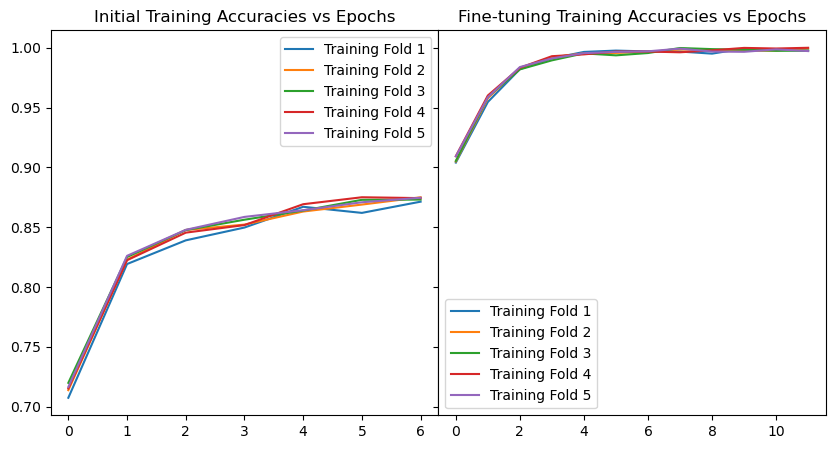

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot the initial history on the left subplot
ax1.set_title('Initial Training Accuracies vs Epochs')
label_name = ''
for i in range(min(fold, num_folds)):
    label_name = 'Training Fold ' + str(i+1)
    ax1.plot(initial_training_history[i].history['accuracy'], label=label_name)
ax1.legend()

# Plot the fine-tuning history on the right subplot
ax2.set_title('Fine-tuning Training Accuracies vs Epochs')
label_name = ''
for i in range(min(fold, num_folds)):
    label_name = 'Training Fold ' + str(i+1)
    ax2.plot(fine_tuning_history[i].history['accuracy'], label=label_name)
ax2.legend()

plt.subplots_adjust(wspace=0)
plt.show()

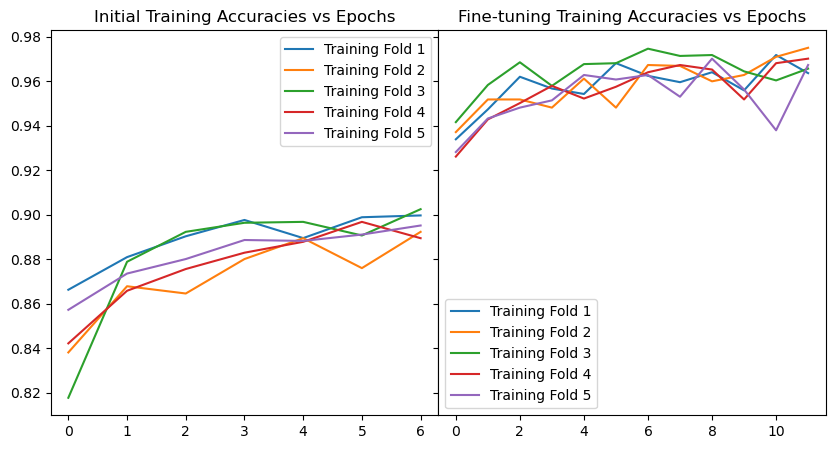

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot the initial history on the left subplot
ax1.set_title('Initial Training Accuracies vs Epochs')
label_name = ''
for i in range(min(fold, num_folds)):
    label_name = 'Training Fold ' + str(i+1)
    ax1.plot(initial_training_history[i].history['val_accuracy'], label=label_name)
ax1.legend()

# Plot the fine-tuning history on the right subplot
ax2.set_title('Fine-tuning Training Accuracies vs Epochs')
label_name = ''
for i in range(min(fold, num_folds)):
    label_name = 'Training Fold ' + str(i+1)
    ax2.plot(fine_tuning_history[i].history['val_accuracy'], label=label_name)
ax2.legend()

plt.subplots_adjust(wspace=0)
plt.show()

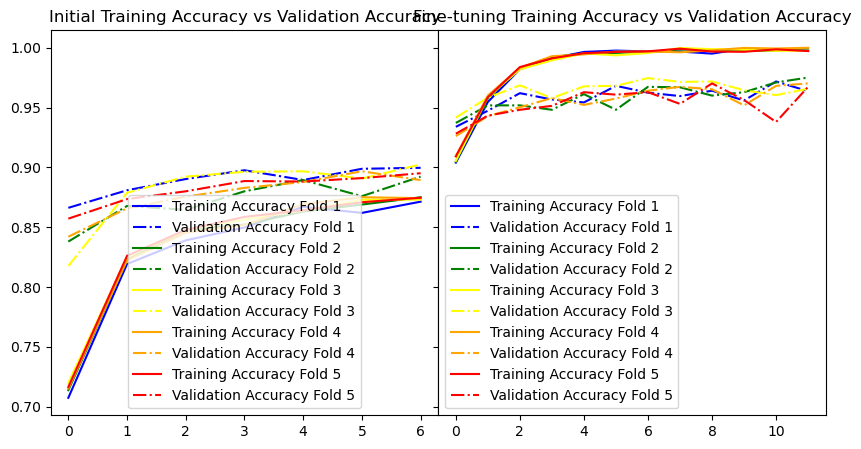

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot the initial history on the left subplot
ax1.set_title('Initial Training Accuracy vs Validation Accuracy')
train_label = '' 
val_label = ''
colors = ['blue', 'green', 'yellow', 'orange', 'red', 'black']
for i in range(min(fold, num_folds)):
    train_label = 'Training Accuracy Fold ' + str(i+1)
    val_label = 'Validation Accuracy Fold ' + str(i+1)
    ax1.plot(initial_training_history[i].history['accuracy'], label=train_label, color=colors[i])
    ax1.plot(initial_training_history[i].history['val_accuracy'], label=val_label, color=colors[i], linestyle = "dashdot")
ax1.legend()

# Plot the fine-tuning history on the right subplot
ax2.set_title('Fine-tuning Training Accuracy vs Validation Accuracy')
train_label = '' 
val_label = ''
colors = ['blue', 'green', 'yellow', 'orange', 'red', 'black']
for i in range(min(fold, num_folds)):
    train_label = 'Training Accuracy Fold ' + str(i+1)
    val_label = 'Validation Accuracy Fold ' + str(i+1)
    ax2.plot(fine_tuning_history[i].history['accuracy'], label=train_label, color=colors[i])
    ax2.plot(fine_tuning_history[i].history['val_accuracy'], label=val_label, color=colors[i], linestyle = "dashdot")
ax2.legend()

plt.subplots_adjust(wspace=0)
plt.show()

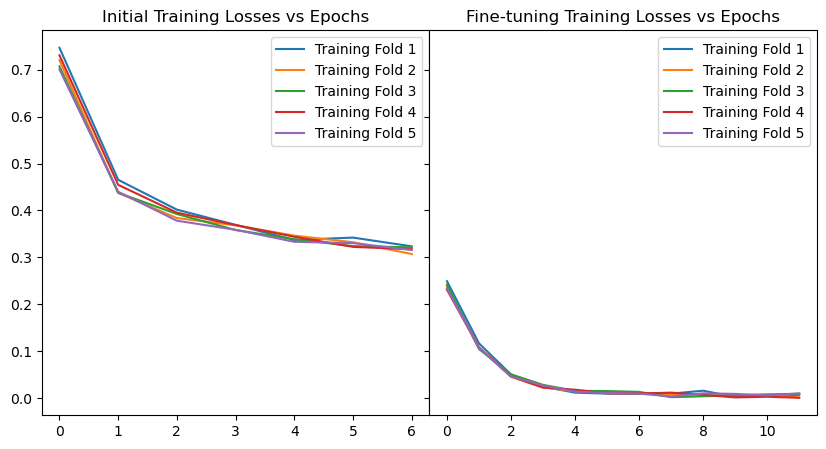

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot the initial history on the left subplot
ax1.set_title('Initial Training Losses vs Epochs')
label_name = ''
for i in range(min(fold, num_folds)):
    label_name = 'Training Fold ' + str(i+1)
    ax1.plot(initial_training_history[i].history['loss'], label=label_name)
ax1.legend()

# Plot the fine-tuning history on the right subplot
ax2.set_title('Fine-tuning Training Losses vs Epochs')
label_name = ''
for i in range(min(fold, num_folds)):
    label_name = 'Training Fold ' + str(i+1)
    ax2.plot(fine_tuning_history[i].history['loss'], label=label_name)
ax2.legend()

plt.subplots_adjust(wspace=0)
plt.show()

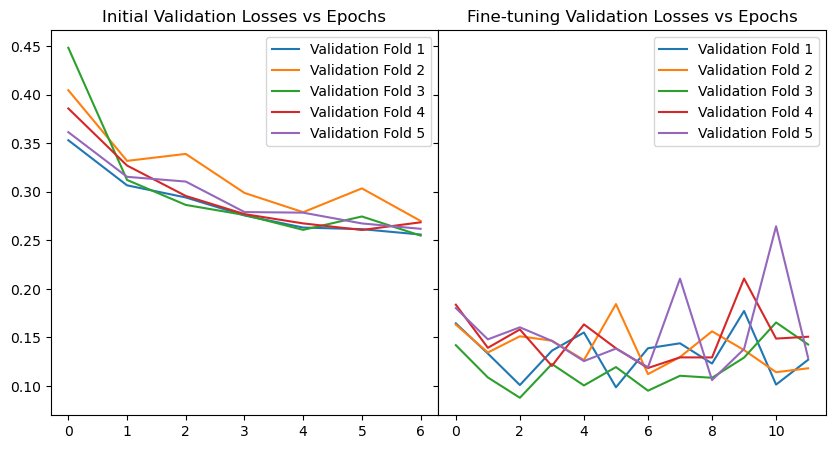

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot the initial history on the left subplot
ax1.set_title('Initial Validation Losses vs Epochs')
label_name = ''
for i in range(min(fold, num_folds)):
    label_name = 'Validation Fold ' + str(i+1)
    ax1.plot(initial_training_history[i].history['val_loss'], label=label_name)
ax1.legend()

# Plot the fine-tuning history on the right subplot
ax2.set_title('Fine-tuning Validation Losses vs Epochs')
label_name = ''
for i in range(min(fold, num_folds)):
    label_name = 'Validation Fold ' + str(i+1)
    ax2.plot(fine_tuning_history[i].history['val_loss'], label=label_name)
ax2.legend()

plt.subplots_adjust(wspace=0)
plt.show()

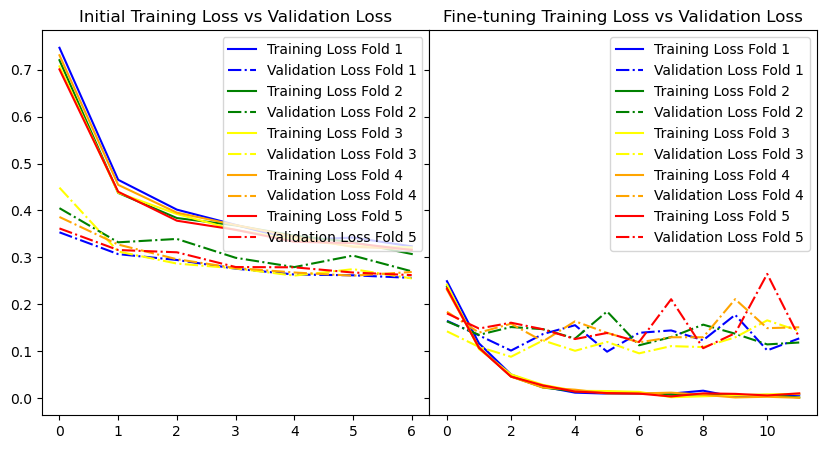

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot the initial history on the left subplot
ax1.set_title('Initial Training Loss vs Validation Loss')
train_label = '' 
val_label = ''
colors = ['blue', 'green', 'yellow', 'orange', 'red', 'black']
for i in range(min(fold, num_folds)):
    train_label = 'Training Loss Fold ' + str(i+1)
    val_label = 'Validation Loss Fold ' + str(i+1)
    ax1.plot(initial_training_history[i].history['loss'], label=train_label, color=colors[i])
    ax1.plot(initial_training_history[i].history['val_loss'], label=val_label, color=colors[i], linestyle = "dashdot")
ax1.legend()

# Plot the fine-tuning history on the right subplot
ax2.set_title('Fine-tuning Training Loss vs Validation Loss')
train_label = '' 
val_label = ''
colors = ['blue', 'green', 'yellow', 'orange', 'red', 'black']
for i in range(min(fold, num_folds)):
    train_label = 'Training Loss Fold ' + str(i+1)
    val_label = 'Validation Loss Fold ' + str(i+1)
    ax2.plot(fine_tuning_history[i].history['loss'], label=train_label, color=colors[i])
    ax2.plot(fine_tuning_history[i].history['val_loss'], label=val_label, color=colors[i], linestyle = "dashdot")
ax2.legend()

plt.subplots_adjust(wspace=0)
plt.show()

In [20]:
# Print the average accuracy across all folds
print(f'Average accuracy: {np.mean(acc_per_fold)}')
print(f'Standard deviation in accuracy: {np.std(acc_per_fold)}')

Average accuracy: 0.9684240102767945
Standard deviation in accuracy: 0.0039655875345529935


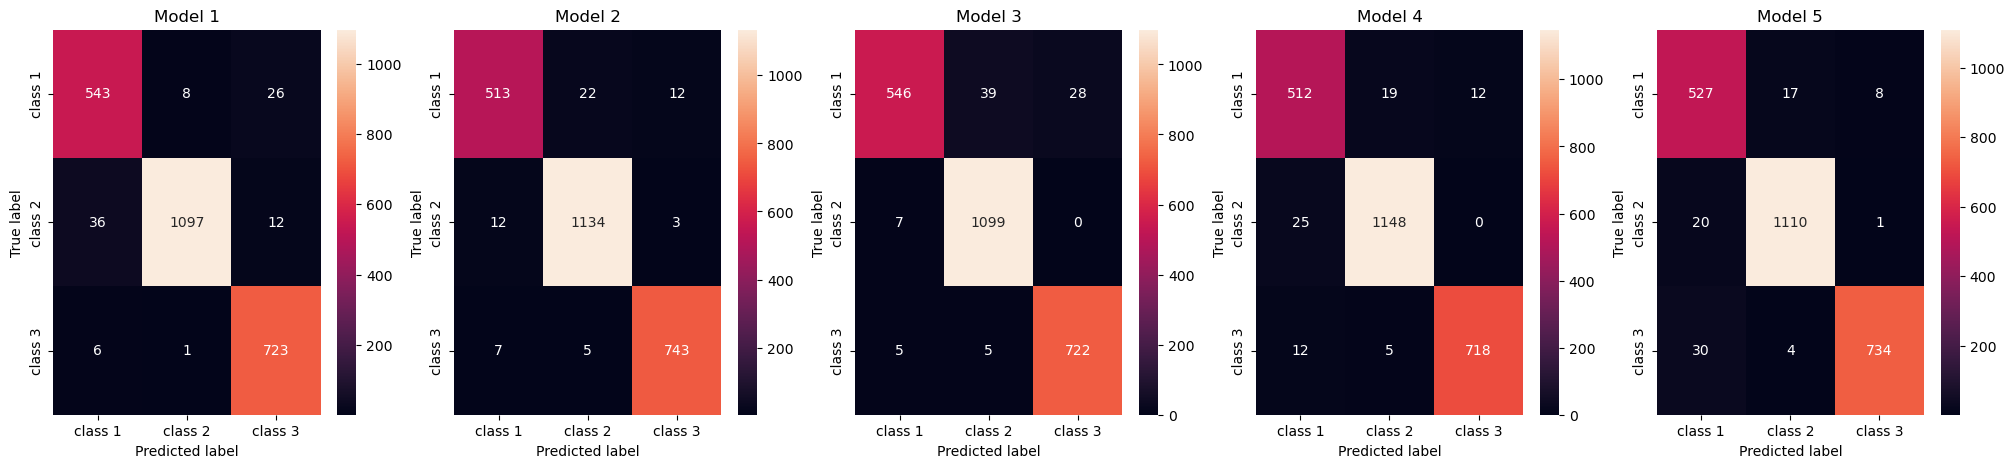

In [21]:
def display_confusion_matrices(metrics_list, class_labels, k=5):
    n_models = min(k, len(metrics_list))
    
    if n_models == 1:
        fig, ax = plt.subplots(1, n_models, figsize=(5 * n_models, 5))
        axes = [ax]
    else:
        fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5))
    
    for i in range(n_models):
        metrics = metrics_list[i]
        confusion_matrix = metrics['confusion_matrix']
        sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
        axes[i].set_xlabel('Predicted label')
        axes[i].set_ylabel('True label')
        axes[i].set_title(f'Model {i+1}')
    
    plt.show()
    
    return
    
class_labels = ['class 1', 'class 2', 'class 3']
display_confusion_matrices(metrics_per_fold, class_labels)

In [22]:
def print_metrics_per_fold(metrics_per_fold):
    for i, metrics in enumerate(metrics_per_fold):
        print(f'------------------------------- FOLD {i+1} -------------------------------')
        for metric_name, metric_value in metrics.items():
            if(metric_name == 'classification_report' or metric_name == 'confusion_matrix'):
                print(f'  {metric_name}:')
                print(f'  {metric_value}')
            else:
                print(f'  {metric_name}: {metric_value}')

    return
print_metrics_per_fold(metrics_per_fold)

------------------------------- FOLD 1 -------------------------------
  accuracy: 0.9637030995106036
  classification_report:
                precision    recall  f1-score   support

     class 1       0.93      0.94      0.93       577
     class 2       0.99      0.96      0.97      1145
     class 3       0.95      0.99      0.97       730

    accuracy                           0.96      2452
   macro avg       0.96      0.96      0.96      2452
weighted avg       0.96      0.96      0.96      2452

  f1_weighted: 0.9637992023651047
  f1_macro: 0.95969745312063
  f1_micro: 0.9637030995106036
  precision_weighted: 0.9644392179140832
  precision_macro: 0.956711133013134
  precision_micro: 0.9637030995106036
  recall_weighted: 0.9637030995106036
  recall_macro: 0.9631880283070258
  recall_micro: 0.9637030995106036
  roc_auc_ovr_macro: 0.997220361809909
  roc_auc_ovr_weighted: 0.9976359932995571
  roc_auc_ovo_macro: 0.9971053040268995
  roc_auc_ovo_weighted: 0.997252464465064
  matthe